# Womens Classifier Analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA, IncrementalPCA
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, OneHotEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from transformers import pipeline

# Functions

In [79]:
def check_class_imbalance(target, type=None):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10,7))
  plt.title("Target Class Breakdown")
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Classes")
  plt.ylabel("Frequency")
  plt.xticks(rotation=45)
  plt.show()

def check_nulls_dupes(df):
  print(f"The amount of Nulls: {df.isna().sum()}")
  print(f"The amount of Dupe: {df.duplicated().sum()}")
  
def view_dist(df, col_type):
  
  plt.figure(figsize=(10, 7))
  rows = len(df.columns)
  dims = (rows +4)//3

  for idx, col in enumerate(df.columns):
    plt.subplot(dims, 4, idx+1)
    sns.histplot(df[col], kde=True) if col_type == "hist" else sns.boxplot(df[col])
    plt.xlabel(col)
    plt.ylabel("Fequency")

  plt.tight_layout()
  plt.show()
  
def aggregate_views(df, interested_columns, agg_col, function):
  
  for col in interested_columns:
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    plt.figure(figsize=(10, 7))
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.show()

def remove_stop_words(review):
  word_tokens = " ".join(word_tokenize(review))
  filtered_tokens = re.sub(r"[^a-zA-Z\s]", "", word_tokens).split(" ")
  filtered_sentence = [w.lower().strip() for w in filtered_tokens if w.lower().strip() not in ENGLISH_STOP_WORDS]
  return " ".join(filtered_sentence).strip()

def lemmatize_words(review):
  lemma = WordNetLemmatizer()
  stop_free = " ".join([word for word in review.lower().split() if word not in ENGLISH_STOP_WORDS])
  punc_free = "".join(re.sub(r"[^a-zA-Z\s]", "", stop_free))
  lemmatize_words = " ".join([lemma.lemmatize(word) for word in punc_free.split()])
  return lemmatize_words

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

def create_pipeline(model):
  
  return Pipeline(steps=[
    ("Scaler", MinMaxScaler()),
    ("Power", PowerTransformer()),
    ("model", model)
  ])

def pca_analysis(X):
  
  n_components = 100
  batch_size=500
  ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)
  scaler = MinMaxScaler()
  X_scaled = scaler.fit_transform(X)
  for i in range(0, X_scaled.shape[0], batch_size):
    X_pca = ipca.partial_fit(X[i:i+batch_size])
  
  X_reduced = ipca.transform(X_scaled)
  print(X_reduced.shape)
  print("Explained Variance Ratio:", X_pca.explained_variance_ratio_.sum())
  
  plt.figure(figsize=(10, 7))
  plt.plot(np.cumsum(X_pca.explained_variance_ratio_))
  plt.xlabel("Number of Components")
  plt.ylabel("Cum Explained Variance")
  plt.title("Explained Variance By Components")
  plt.grid(True)
  plt.show()
  

def grab_selected_models(names):
  
  models = {
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "DUMMY": DummyClassifier(strategy="constant", constant=1)
  }
  
  return [models[model_name] for model_name in names]

# EDA Analysis

In [80]:
df = pd.read_csv("/Users/maukanmir/Downloads/ecommerce.csv", delimiter=';')
df

,Unnamed: 0,Clothing.ID,Age,Title,Review.Text,Rating,Recommended.IND,Positive.Feedback.Count,Division.Name,Department.Name,Class.Name
0,1,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,2,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,3,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,4,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,5,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23482,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23483,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23484,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23485,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


# Shuffle Dataset

In [81]:
df = df.sample(frac=1).reset_index(drop=True)

# Drop Useless Columns

In [82]:
df.drop(["Unnamed: 0", "Clothing.ID"], axis=1, inplace=True)

# Check For Nulls and Dupes

In [83]:
check_nulls_dupes(df)

The amount of Nulls: Age                           0
Title                      3810
Review.Text                 845
Rating                        0
Recommended.IND               0
Positive.Feedback.Count       0
Division.Name                14
Department.Name              14
Class.Name                   14
dtype: int64
The amount of Dupe: 232


In [84]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [85]:
df.shape

(19661, 9)

# Check Class Imbalance

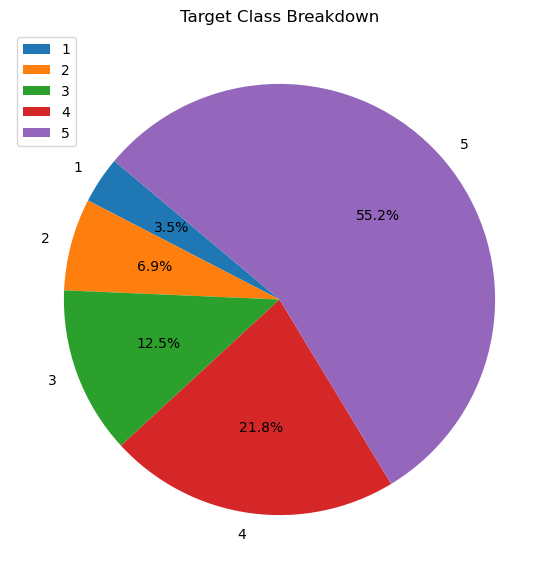

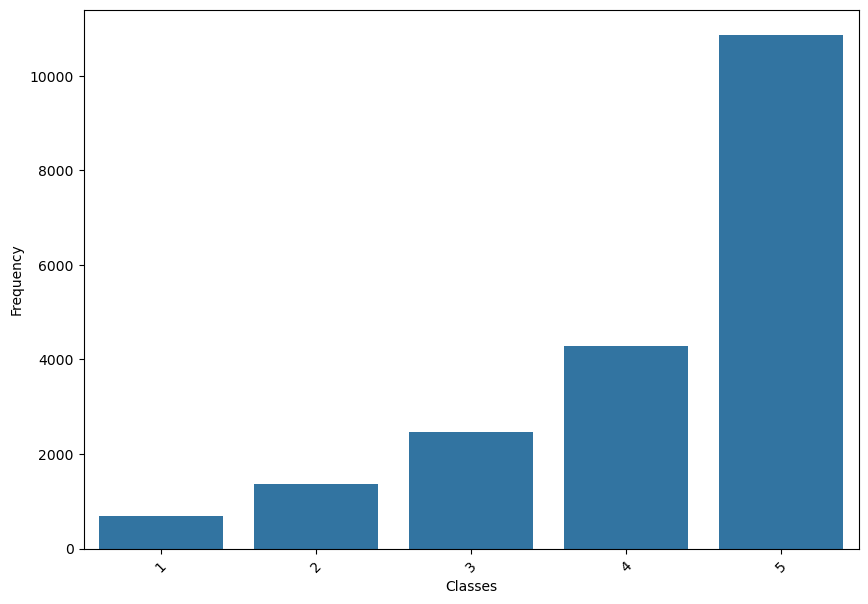

In [86]:
check_class_imbalance(df["Rating"])

# Class Imbalance Exists

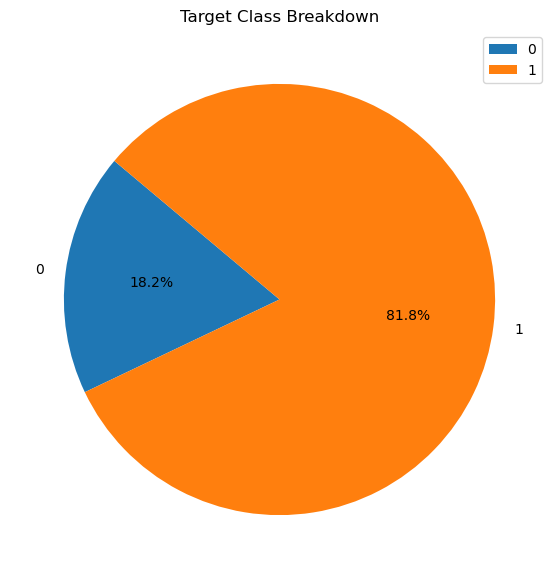

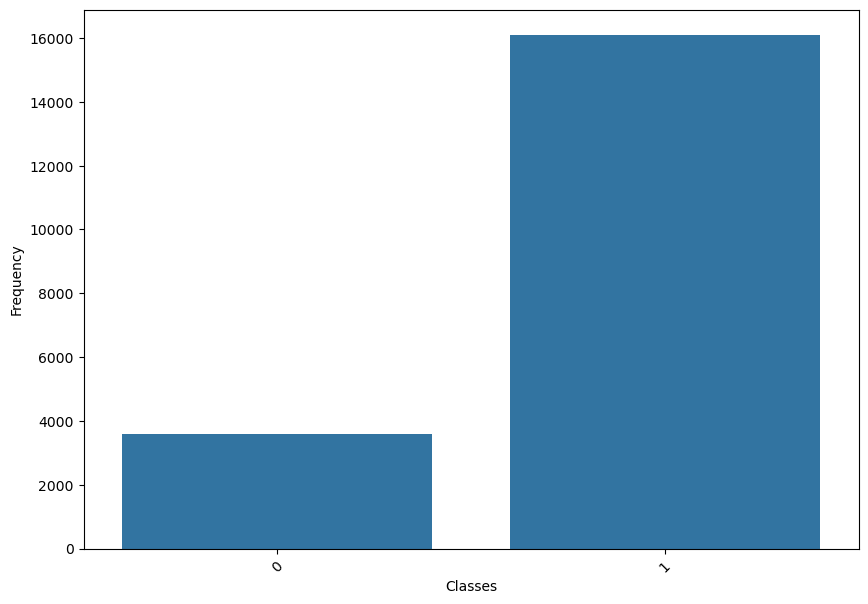

In [87]:
check_class_imbalance(df["Recommended.IND"])

# 80% of the customers either recommend the clothing. 

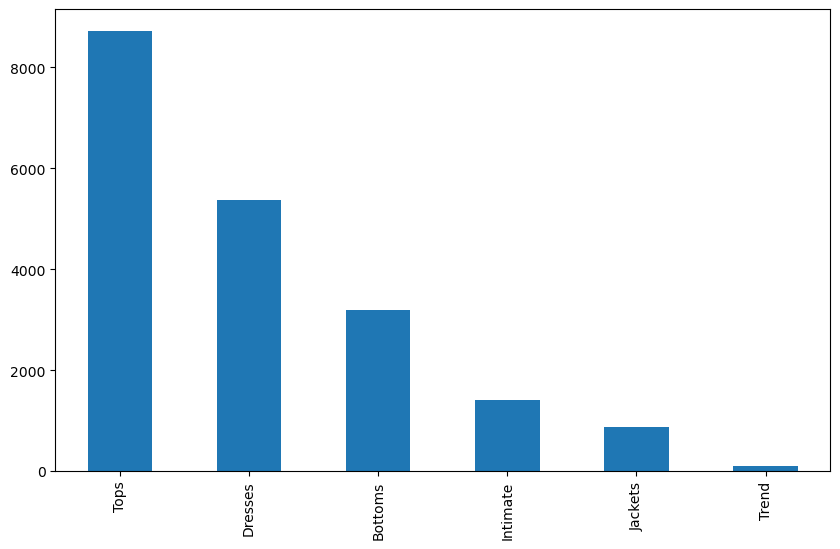

In [88]:
plt.figure(figsize=(10, 6))
df["Department.Name"].value_counts().plot.bar(x="Classes", y="Counts")
plt.show()

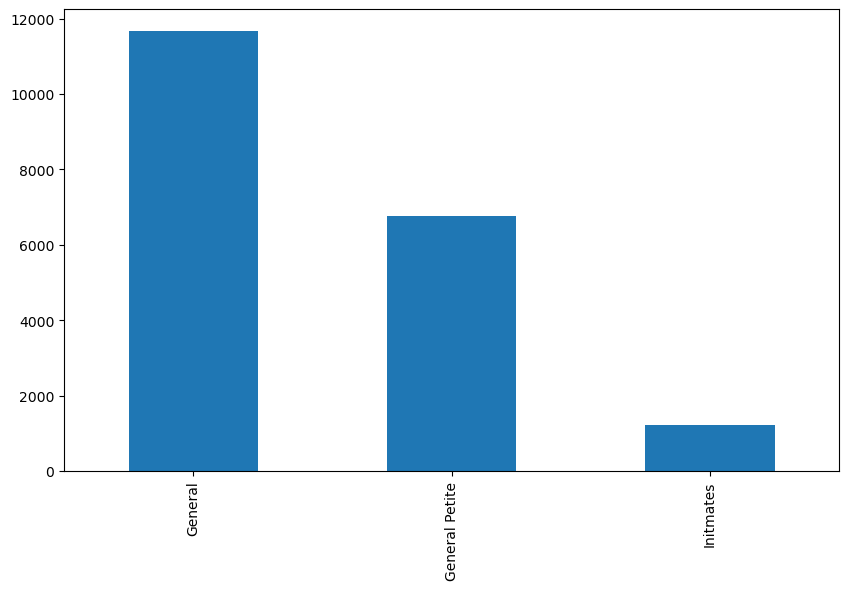

In [89]:
plt.figure(figsize=(10, 6))
df["Division.Name"].value_counts().plot.bar(x="Classes", y="Counts")
plt.show()

In [90]:
df.describe()

,Age,Rating,Recommended.IND,Positive.Feedback.Count
count,19661.000000,19661.000000,19661.000000,19661.000000
mean,43.261686,4.183104,0.818168,2.652612
std,12.257816,1.112237,0.385716,5.834402
min,18.000000,1.000000,0.000000,0.000000
25%,34.000000,4.000000,1.000000,0.000000
50%,41.000000,5.000000,1.000000,1.000000
75%,52.000000,5.000000,1.000000,3.000000
max,99.000000,5.000000,1.000000,122.000000


In [91]:
df.dtypes

Age                         int64
Title                      object
Review.Text                object
Rating                      int64
Recommended.IND             int64
Positive.Feedback.Count     int64
Division.Name              object
Department.Name            object
Class.Name                 object
dtype: object

In [92]:
df["len_review"] = df["Review.Text"].apply(lambda x: len(x))
df["num_words"] = df["Review.Text"].apply(lambda x: len(x.split()))

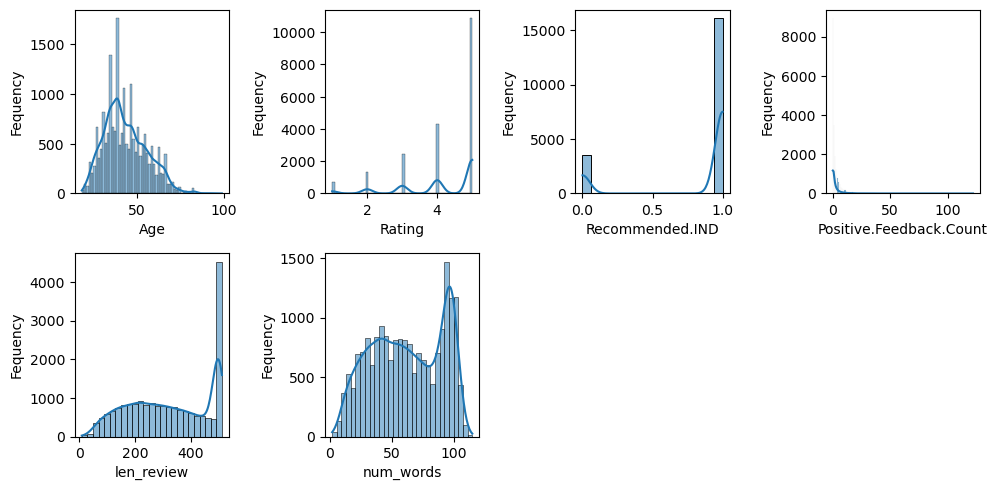

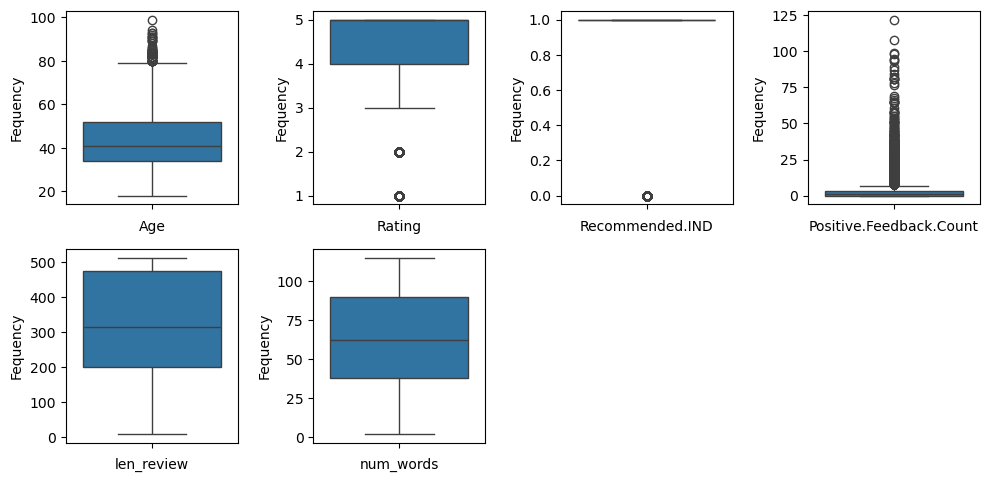

In [93]:
numerical_features = df.select_dtypes(include="int64")

view_dist(numerical_features, "hist")
view_dist(numerical_features, "box")

# Heatmap

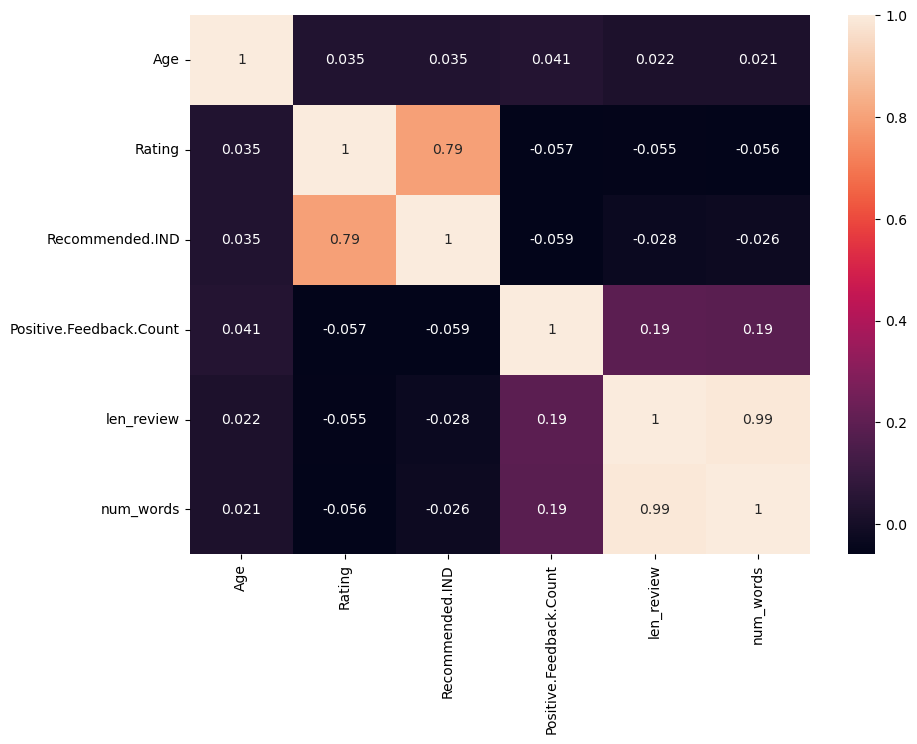

In [94]:
plt.figure(figsize=(10, 7))
sns.heatmap(data=numerical_features.corr(), annot=True)
plt.show()

# Given some of these correlations, lets try and see if they show up in scatter plots

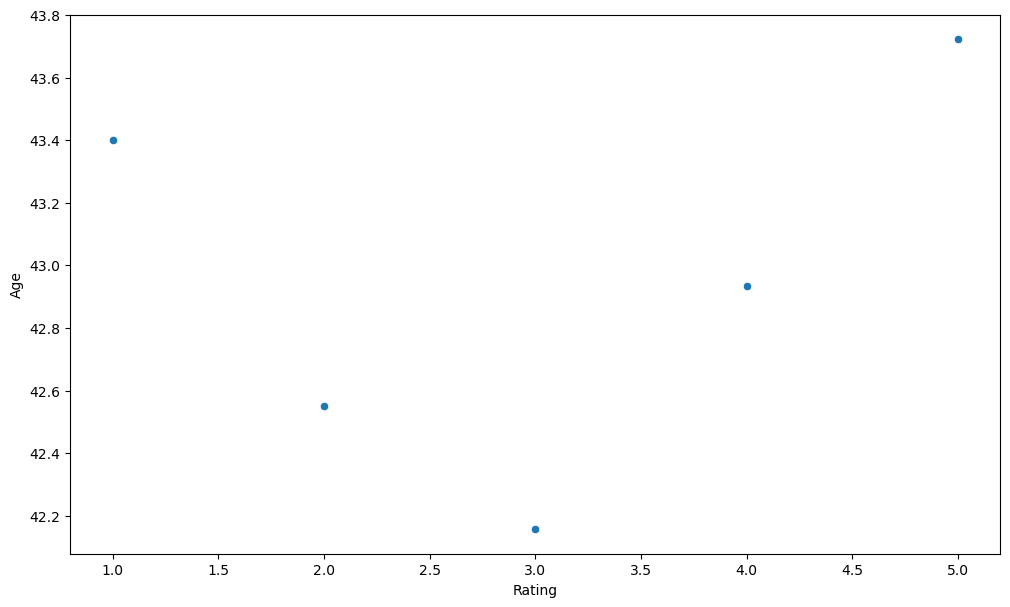

In [95]:
plt.figure(figsize=(12, 7))
grouped_df = numerical_features.groupby("Rating")["Age"].mean().reset_index()
sns.scatterplot(data=grouped_df, x="Rating", y="Age")
plt.show()

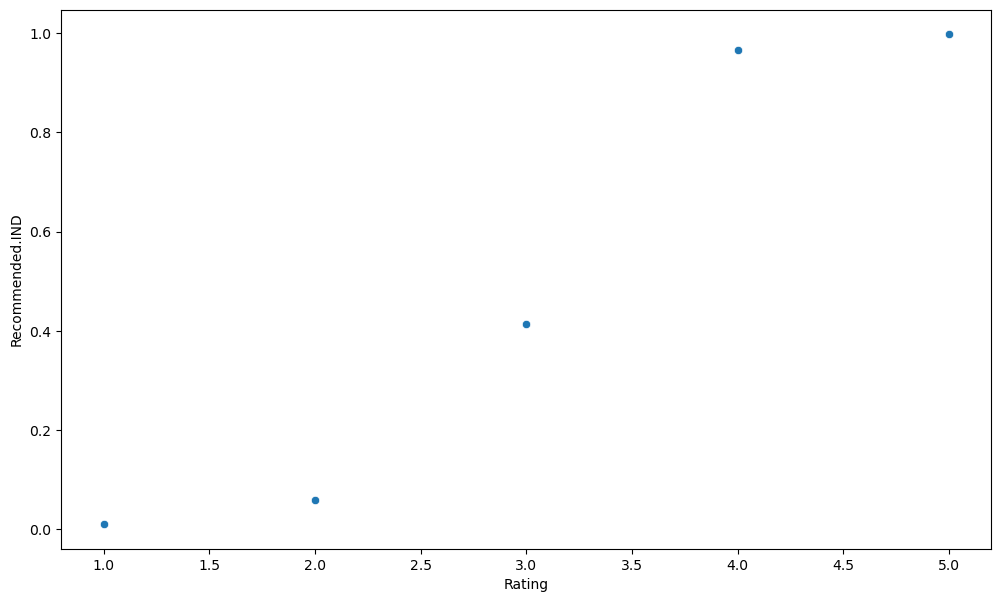

In [96]:
plt.figure(figsize=(12, 7))
grouped_df = numerical_features.groupby("Rating")["Recommended.IND"].mean().reset_index()
sns.scatterplot(data=grouped_df, x="Rating", y="Recommended.IND")
plt.show()

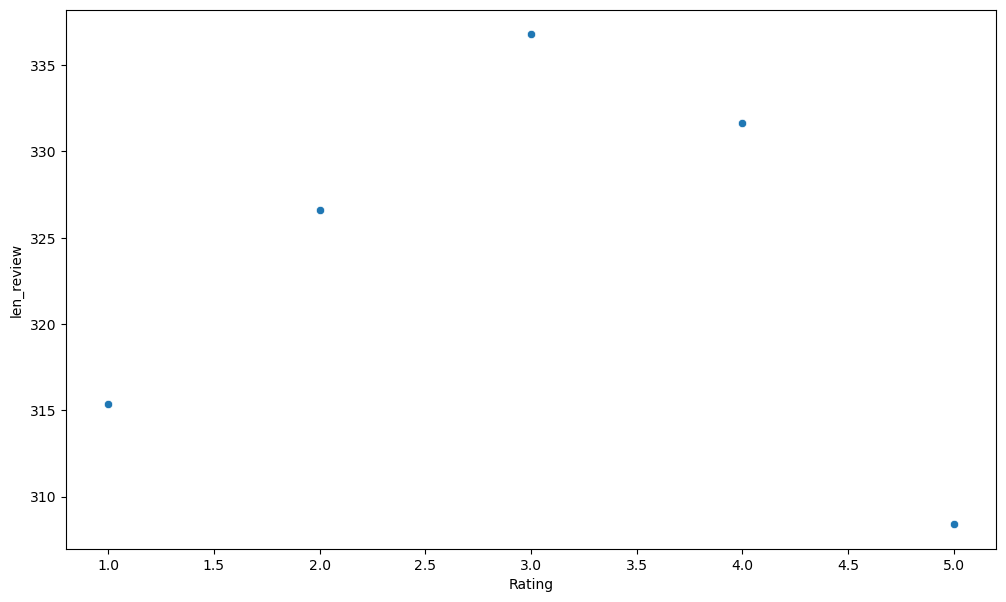

In [97]:
plt.figure(figsize=(12, 7))
grouped_df = numerical_features.groupby("Rating")["len_review"].mean().reset_index()
sns.scatterplot(data=grouped_df, x="Rating", y="len_review")
plt.show()

# Bert Sentiment Pipeline

In [98]:
clf = pipeline("sentiment-analysis")
clf

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


# Remove Stop Words

In [99]:
df["cleaned_content"] = df["Review.Text"].apply(remove_stop_words)

In [100]:
df["sentiment_test"] = df["cleaned_content"].apply(lambda review: clf(review)[0])

In [101]:
df["labels"] = df["sentiment_test"].apply(lambda x: x['label'])
df['scores'] = df["sentiment_test"].apply(lambda x: x['score'])

# Check Imbalance for Labels

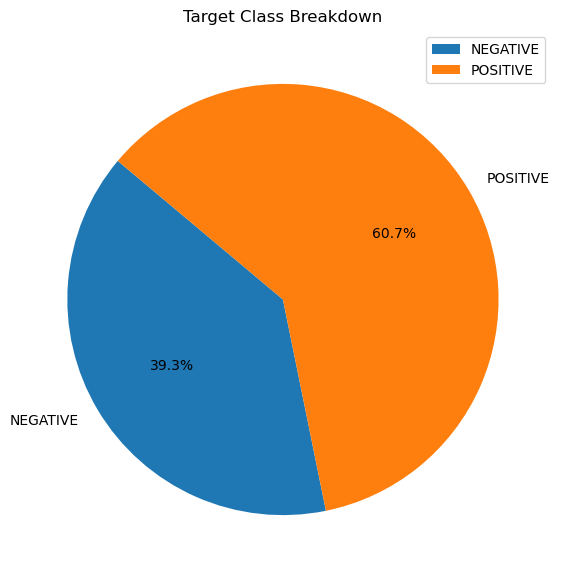

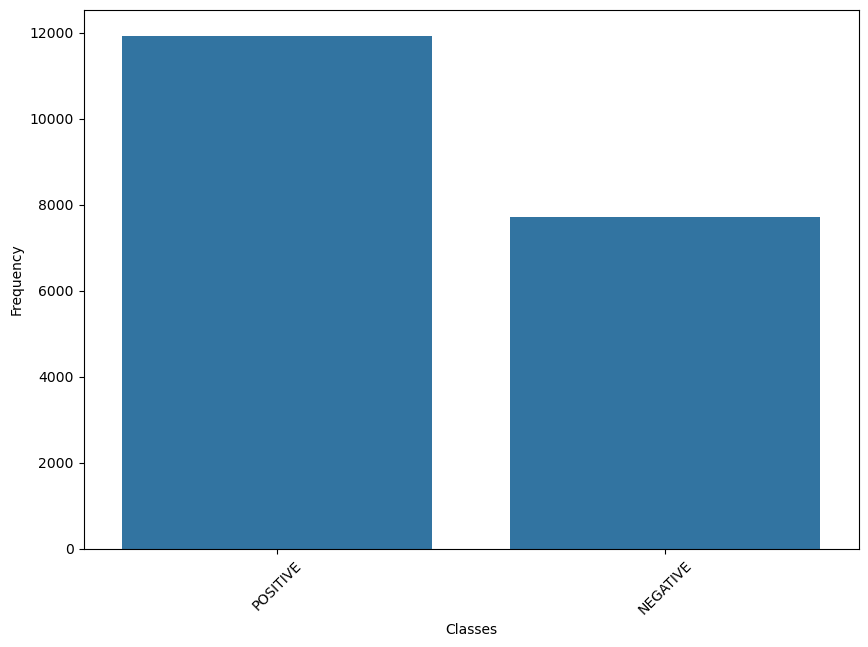

In [102]:
check_class_imbalance(df["labels"])

# No entries below 50%

In [103]:
df[df["scores"] <= 0.50]

,Age,Title,Review.Text,Rating,Recommended.IND,Positive.Feedback.Count,Division.Name,Department.Name,Class.Name,len_review,num_words,cleaned_content,sentiment_test,labels,scores


# Entries below 60%

In [104]:
df[df["scores"] <= 0.60]

,Age,Title,Review.Text,Rating,Recommended.IND,Positive.Feedback.Count,Division.Name,Department.Name,Class.Name,len_review,num_words,cleaned_content,sentiment_test,labels,scores
2,58,A wardrobe essential,You must have this vest for your fall/winter w...,5,1,0,General,Jackets,Outerwear,495,91,vest fallwinter wardrobe design extremely fla...,"{'label': 'POSITIVE', 'score': 0.5011398196220...",POSITIVE,0.501140
27,40,Flirty with an odd fit,This dress is so light and twirly and the fabr...,4,1,3,General Petite,Trend,Trend,349,77,dress light twirly fabric airy pretty sadly f...,"{'label': 'NEGATIVE', 'score': 0.5766018033027...",NEGATIVE,0.576602
40,68,The best basic tee,"If you like a slightly heavier, non/clingy bas...",5,1,0,General,Tops,Knits,309,56,like slightly heavier nonclingy basic tee w...,"{'label': 'NEGATIVE', 'score': 0.5913922190666...",NEGATIVE,0.591392
125,51,Tapestry skirt,I found this skirt beautiful for year round we...,5,1,0,General Petite,Bottoms,Skirts,500,104,skirt beautiful year round wearing s lined tt...,"{'label': 'POSITIVE', 'score': 0.5939478874206...",POSITIVE,0.593948
154,57,Classic!,"Very flattering, sliming and feminine. i parti...",4,1,2,General,Tops,Knits,117,19,flattering sliming feminine particularly lik...,"{'label': 'POSITIVE', 'score': 0.5248108506202...",POSITIVE,0.524811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23240,54,Vibrant colors & sweet side detail,Love the mara hoffman basketweave bikini botto...,5,1,0,Initmates,Intimate,Swim,500,96,love mara hoffman basketweave bikini bottoms f...,"{'label': 'NEGATIVE', 'score': 0.5841764807701...",NEGATIVE,0.584176
23255,51,Not the same...,"I agree with other reviewer, the material of t...",2,0,0,General,Bottoms,Jeans,292,56,agree reviewer material jeans stretches en...,"{'label': 'POSITIVE', 'score': 0.5962300300598...",POSITIVE,0.596230
23337,36,Soooo comfy,This sweater is super soft and comfortable. ru...,5,1,0,General Petite,Tops,Sweaters,129,25,sweater super soft comfortable runs big usua...,"{'label': 'POSITIVE', 'score': 0.5475842952728...",POSITIVE,0.547584
23470,39,Nice and soft,"Kind of silky, but to a point where they almos...",5,1,2,General,Bottoms,Pants,228,51,kind silky point look like pj pants sure ov...,"{'label': 'POSITIVE', 'score': 0.5660080909729...",POSITIVE,0.566008


In [105]:
df.drop("sentiment_test", axis=1, inplace=True)

In [106]:
df["real_rating"] = df["labels"].apply(lambda sentiment: 1 if sentiment == "POSITIVE" else 0)

# Check Class Imbalance For new Rating

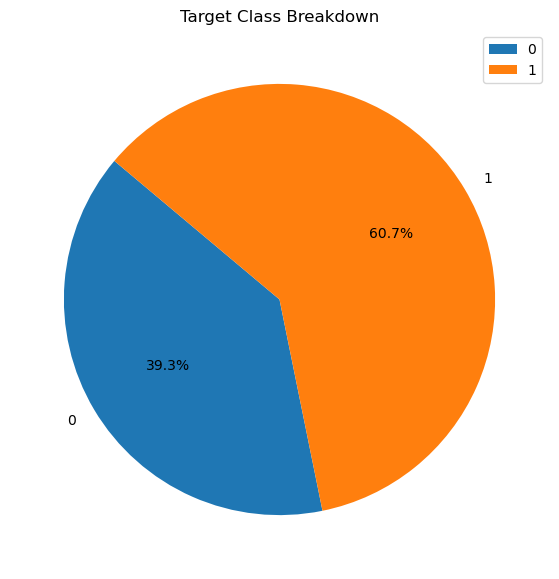

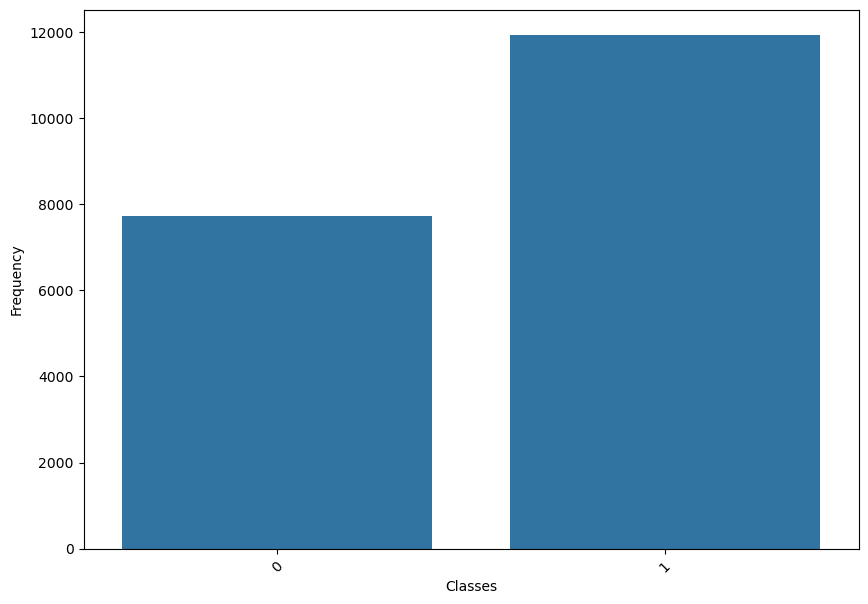

In [129]:
check_class_imbalance(df["real_rating"])

In [107]:
interested_columns = [
  "Recommended.IND", 
  "Positive.Feedback.Count",
  "len_review",
  "num_words",
  "Age"
  ]

# Group By Rating

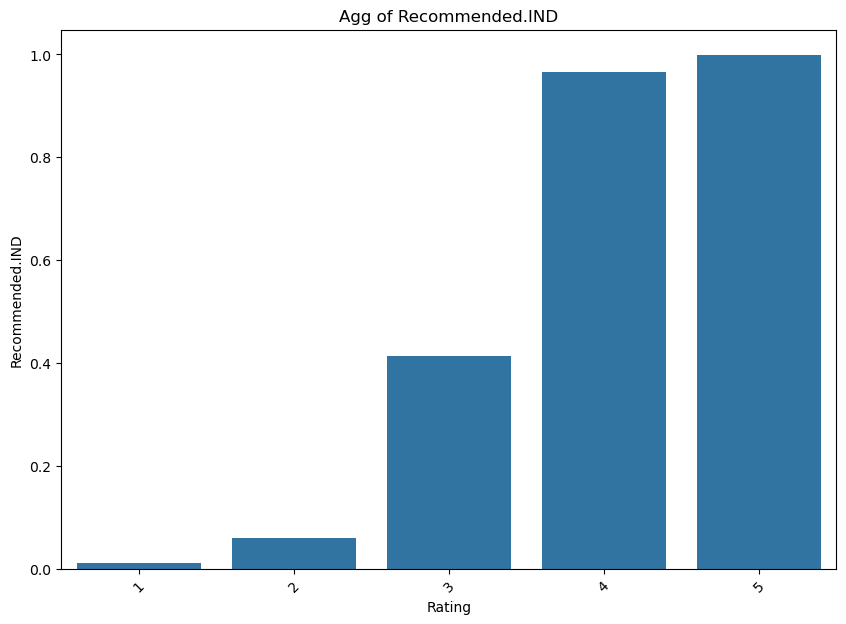

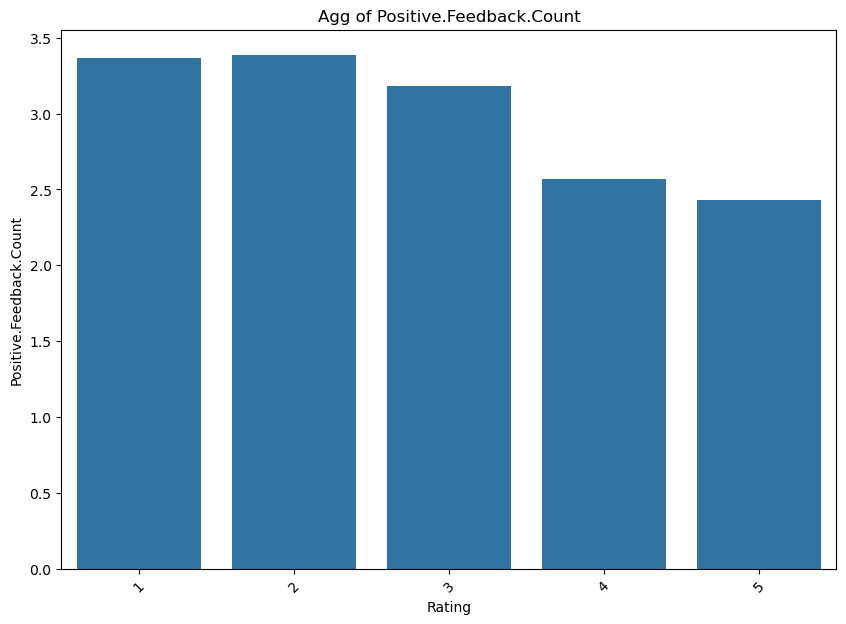

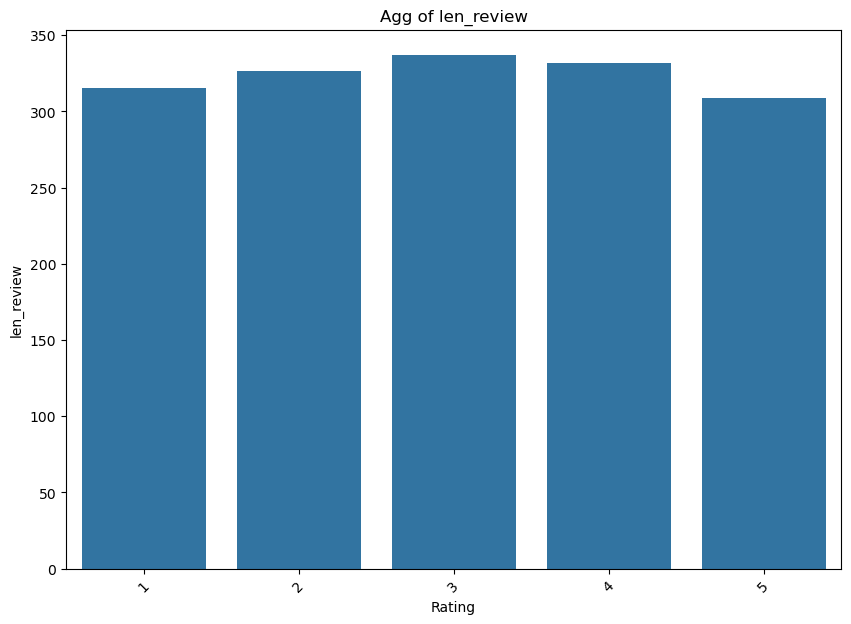

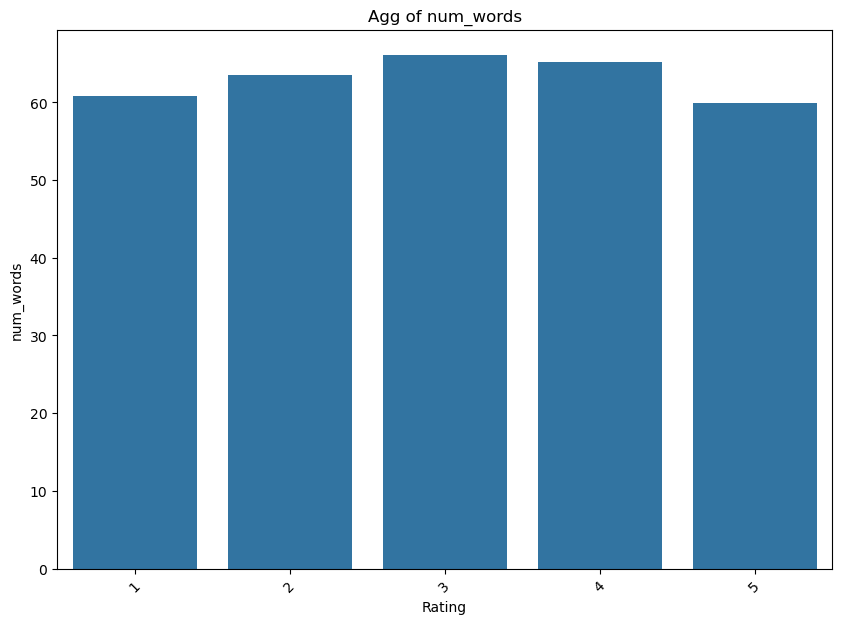

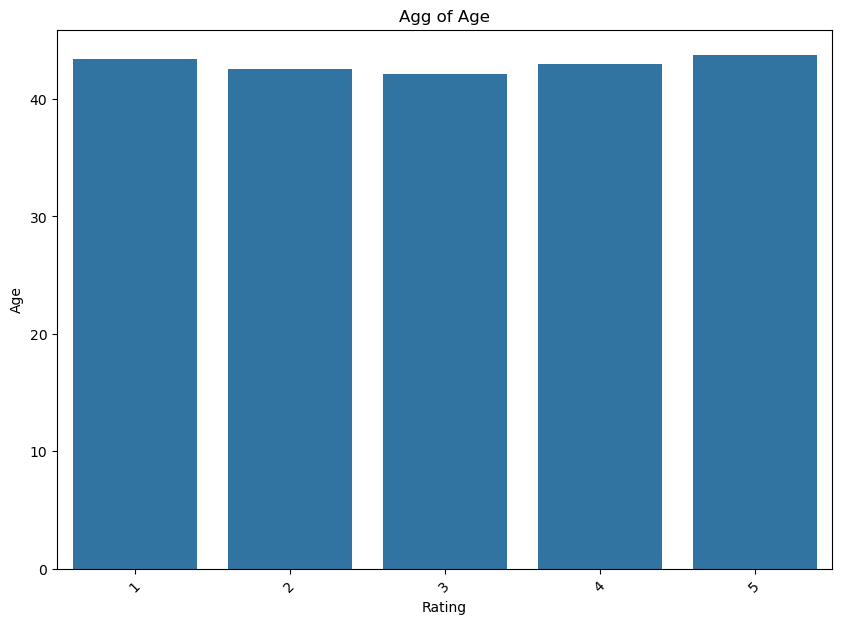

In [108]:
aggregate_views(df, interested_columns,"Rating", "mean")

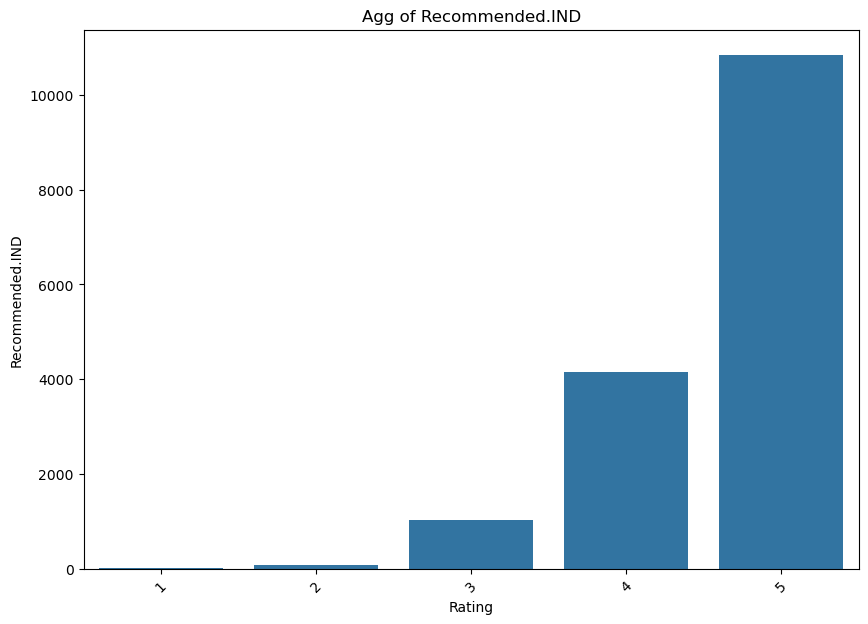

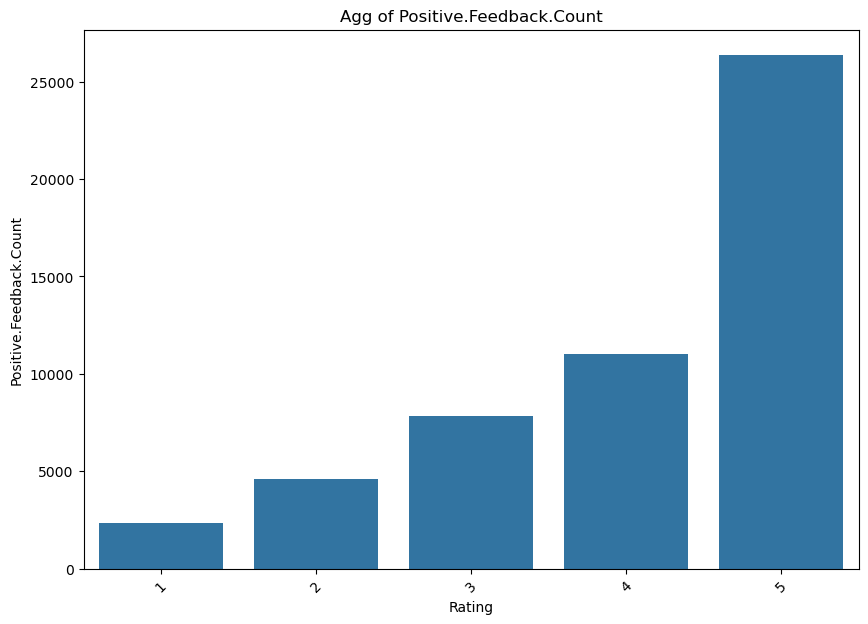

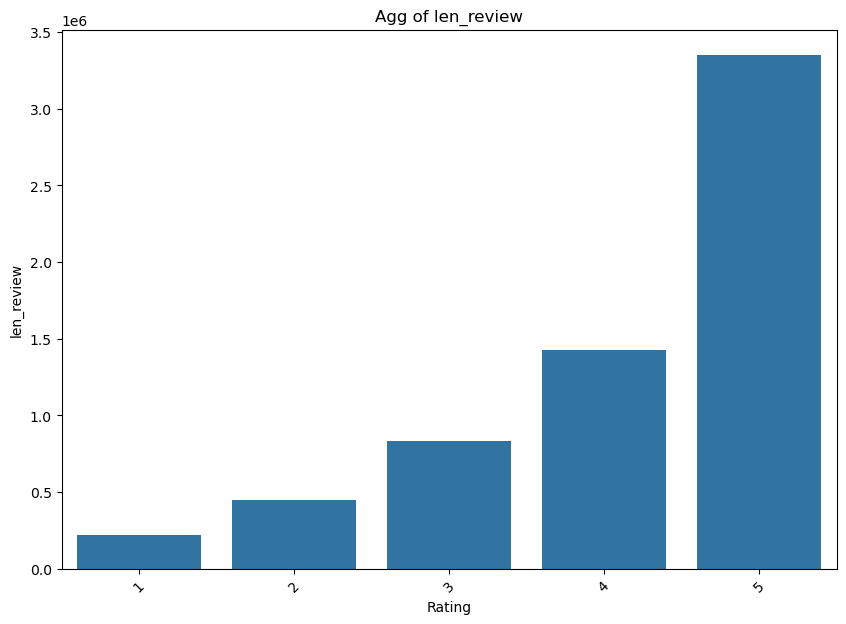

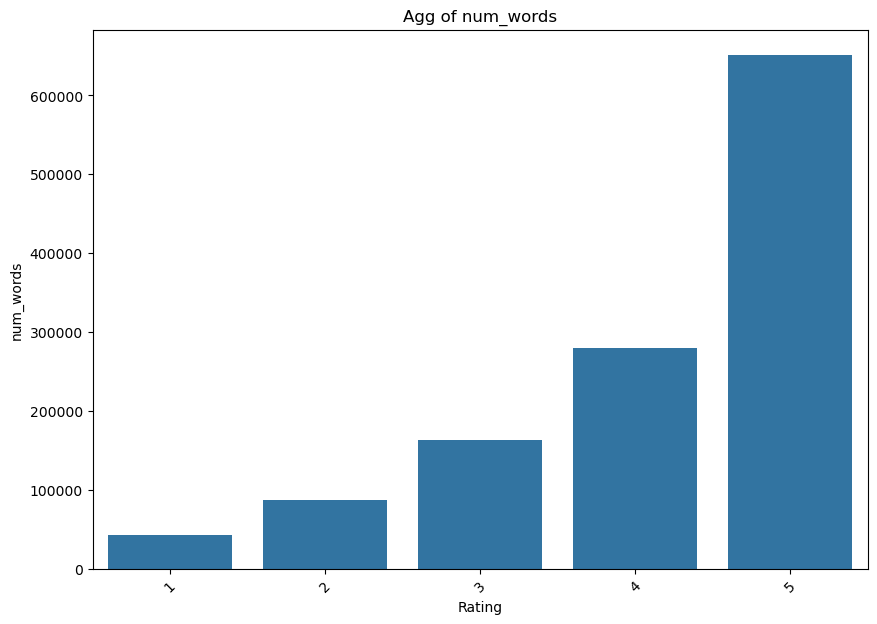

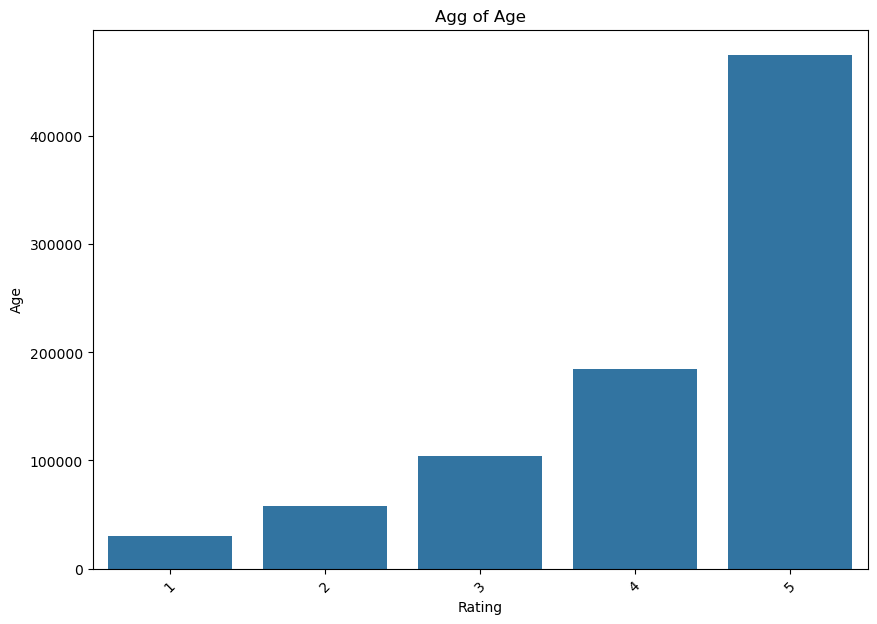

In [109]:
aggregate_views(df, interested_columns,"Rating", "sum")

# Let's find the sentiment of the model and try to figure out if we can consolidate the categories into a binary for our model.

# LDA Analysis

In [110]:
df["LDA_content"] = df["Review.Text"].apply(lemmatize_words)

In [111]:
df["LDA_content"]

0        im going cruise bahamas saw dress it love it i...
1        dress exceptional fit material workmanship sty...
2        vest fallwinter wardrobe design extremely flat...
3        dress look cute model doesnt look like reality...
4        did size one came snug loose shirt sized love ...
                               ...                        
23479    nice weight loved design inside loved most doe...
23481    bomber really superb it want jacket beautiful ...
23482    look great jean bohemian look normally wear me...
23483    liked bought color send berry color back flatt...
23484    adore top tencel fabric feel like nicely worn ...
Name: LDA_content, Length: 19661, dtype: object

# Check For Empty String

In [112]:
df[df['LDA_content'].str.strip() == '']

,Age,Title,Review.Text,Rating,Recommended.IND,Positive.Feedback.Count,Division.Name,Department.Name,Class.Name,len_review,num_words,cleaned_content,labels,scores,real_rating,LDA_content


In [113]:
df[df['cleaned_content'].str.strip() == '']

,Age,Title,Review.Text,Rating,Recommended.IND,Positive.Feedback.Count,Division.Name,Department.Name,Class.Name,len_review,num_words,cleaned_content,labels,scores,real_rating,LDA_content


# LDA Topic Modeling

In [114]:
count_vec = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")
dtm = count_vec.fit_transform(df["LDA_content"])

In [115]:
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='online', random_state=0)
lda.fit(dtm)

LatentDirichletAllocation(learning_method='online', max_iter=5, n_components=5,
                          random_state=0)

In [116]:
no_top_words = 10
display_topics(lda, count_vec.get_feature_names_out(), no_top_words)
topic_values = lda.transform(dtm)
df['topic'] = topic_values.argmax(axis=1)

Topic 0:
size fit small im like just large look ordered little
Topic 1:
color look sweater like store online photo saw tried looked
Topic 2:
love great wear fit perfect color comfortable soft jean bought
Topic 3:
dress fabric beautiful fit like print bra size slip lovely
Topic 4:
blouse high quality worth neck price low dd fabric jean


<AxesSubplot:xlabel='Topic Distribution', ylabel='Counts'>

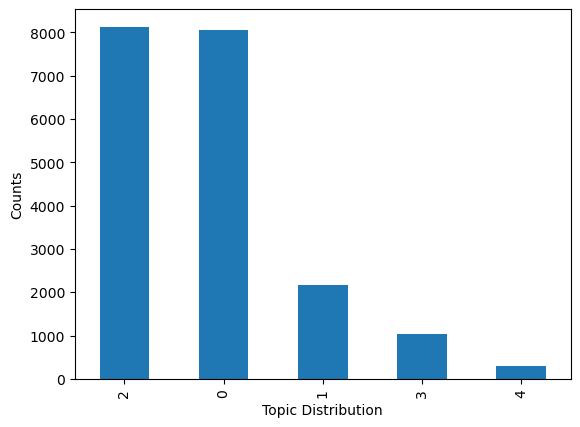

In [117]:
df["topic"].value_counts().plot.bar(xlabel="Topic Distribution", ylabel="Counts")

# Data Preprocessing

In [118]:
crosstab = pd.crosstab(df["Rating"], df['labels'])
crosstab

labels,NEGATIVE,POSITIVE
Rating,,
1,577,114
2,1046,314
3,1628,836
4,1832,2457
5,2645,8212


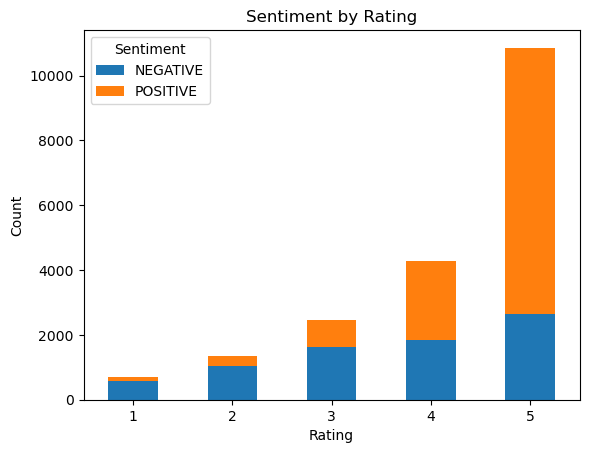

In [119]:
crosstab.plot(kind='bar', stacked=True)
plt.title('Sentiment by Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.show()

In [ ]:
categorical_features = df[df["Division.Name", "Department.Name", "Class.Name"]]
numerical_features = df[df["Age", "len_review", "num_words", "Recommended.IND"]]

cat_cols = categorical_features.columns
numeric_cols = numerical_features.columns

numeric_transformer = Pipeline(steps=[
  ("scaler", MinMaxScaler()),
  ("PowerTransformer", PowerTransformer())
])

cat_transformer = Pipeline(steps=[
  ("encoder", OneHotEncoder())
])

preprocessed = ColumnTransformer(transformers=[
  ("num", numeric_transformer, numeric_cols),
  ("cat", cat_transformer, categorical_features)
])

# Separate Feature Variables

In [120]:
X, y = df[["cleaned_content","Age", "Recommended.IND", "Positive.Feedback.Count", "num_words"]], df["Rating"]

# TFIDF Features

In [121]:
vectorizer = TfidfVectorizer()

tfidf = vectorizer.fit_transform(X["cleaned_content"])
tfidf_features = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names_out())

In [122]:
X_non_text = X.drop("cleaned_content", axis=1).reset_index(drop=True)
X_features = pd.concat([X_non_text, tfidf_features], axis=1)

In [123]:
X_features.shape

(19661, 15298)

In [124]:
X_features.isna().sum()

Age                        0
Recommended.IND            0
Positive.Feedback.Count    0
num_words                  0
aa                         0
                          ..
zone                       0
zoolander                  0
zoom                       0
zooming                    0
zuma                       0
Length: 15298, dtype: int64

In [125]:
X_features.duplicated().sum()

1

In [126]:
X_features.drop_duplicates(inplace=True)

# PCA Analysis

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IncrementalPCA was fitted with feature names
  warnings.warn(


(19660, 100)
Explained Variance Ratio: 0.999237352818973


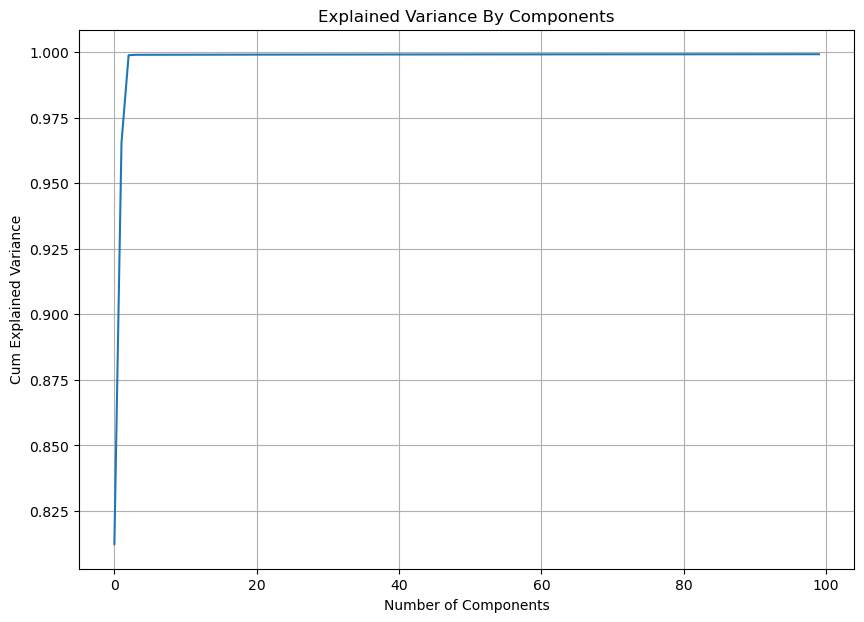

In [127]:
X_reducded = pca_analysis(X_features)

# Dimensionality Reduction

In [128]:
print(f"Reducded our feature space by {15298 - 100} columns")

Reducded our feature space by 15198 columns
